# Simple CRAG - Corrective Retrieval Augmented Generation

Inspiration: https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_crag.ipynb

In [2]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'

## Setup / Grabbing Documents

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
question = "What is few-shot learning?"
docs = retriever.get_relevant_documents(question)
for doc in docs:
    print(doc.page_content[:50], '...', doc.metadata['source'])

Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
Few-shot CoT. It is to prompt the model with a few ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
Zero-shot generation: This is to find a number of  ... https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/
Text: i'll bet the video game is a lot more fun th ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_85152/2952994269.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


## Retrieval Grader / The Corrective Part

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)


# Prompt
system = """Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

for doc in docs:
    doc_txt = doc.page_content
    print(retrieval_grader.invoke({"question": question, "document": doc_txt}), doc_txt[:50], '...', doc.metadata['source'])

binary_score='yes' Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
binary_score='no' Few-shot CoT. It is to prompt the model with a few ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
binary_score='no' Zero-shot generation: This is to find a number of  ... https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/
binary_score='no' Text: i'll bet the video game is a lot more fun th ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/


## Generate Compoments

In [9]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
for message in prompt.messages:
    print(type(message))
    print(message.prompt.template)
    print('-----')

/Users/sinanozdemir/Teaching/Pearson/oreilly-ai-agents/.venv/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


<class 'langchain_core.prompts.chat.HumanMessagePromptTemplate'>
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
-----


In [11]:
# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

Few-shot learning is a machine learning approach where a model is provided with a small number of high-quality examples that include both input and desired output for a specific task. This method helps the model better understand human intentions and criteria, often resulting in improved performance compared to zero-shot learning. However, it requires more tokens and may encounter context length limitations with longer texts.


## Question Re-writer


In [12]:
# A different LLM, just to show we can use multiple LLMs in our calls
three_five_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | three_five_llm | StrOutputParser()
question, question_rewriter.invoke({"question": question})

('What is few-shot learning?',
 'What are the key concepts and applications of few-shot learning in machine learning?')

## Building the Graph

In [10]:
from typing import List

from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        times_transformed: number of times the question has been re-written
    """

    question: str
    generation: str
    documents: List[str]
    times_transformed: int

In [11]:
from langchain.schema import Document


def retrieve(state):
    print(state)
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question, "times_transformed": 0}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": format_docs(documents), "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]
    times_transformed = state["times_transformed"]
    times_transformed += 1

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print('---NEW QUESTION---')
    print(better_question)
    return {"documents": documents, "question": better_question, "times_transformed": times_transformed}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        print(d.metadata['source'], f'Grade: {grade}')
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
    if len(filtered_docs) == 0:
        print("---GRADE: DOCUMENTS NOT RELEVANT---")
        web_search = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    # state["documents"]

    if web_search == "Yes":
        # check times_transformed
        if state["times_transformed"] >= 3:
            print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION AND WE HAVE TRANSFORMED 3 TIMES, GENERATE---"
            )
            return "should_generate"

        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "should_transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "should_generate"

In [12]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "should_transform_query": "transform_query",
        "should_generate": "generate",
    },
)
workflow.add_edge("transform_query", "grade_documents")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

## Running the Graph

In [13]:
# Run
inputs = {"question": "What on earth is few shot learning?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"])

{'question': 'What on earth is few shot learning?'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/ Grade: no
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node 'grade_documents':
---GENERATE---
Node 'generate':
Few-shot learning is a machine learning approach where a model is provided with a small number of high-quality examples of input-output pairs for a specific task. This helps the model understand the desired outcomes better, often leading to improved performance compared to zero-shot learning. However, it requires more tokens and can be limited by context length.


In [14]:
# Run
inputs = {"question": "How should I talk to LLMs?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"])

{'question': 'How should I talk to LLMs?'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/ Grade: no
https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/ Grade: no
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node 'grade_documents':
---GENERATE---
Node 'generate':
To talk to LLMs, provide clear prompts and specify the tools you want them to use. Follow the ReAct format by expressing your thoughts, indicating actions, and detailing the expected input and output. This structured approach helps the model understand and respond effectively.


In [15]:
# Run
inputs = {"question": "How big is the moon?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"])

{'question': 'How big is the moon?'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade_documents':
---TRANSFORM QUERY---
---NEW QUESTION---
What is the size of the moon?
Node 'transform_query':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade_documents':
---TRANSFORM QUERY---
---NEW QUESTION---
What are the dimensions of the moon?
Node 'transform_query':
---CHECK DOCUMENT RELEVANCE

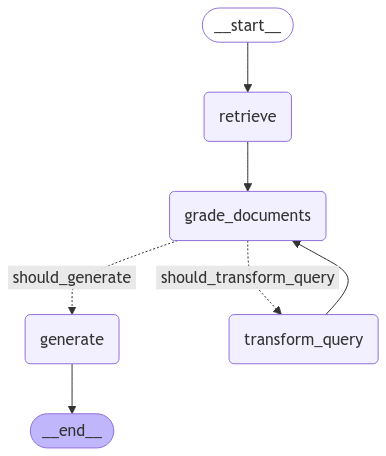

In [16]:
# Visualize our graph
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass